## Experiment Setting: On the impact of features orthogonality for Link Representation Learning with Message Passing Neural Network(MPNN)
This experiment aims to analyze the capacity of MPNNs to capture structural features under varying configurations, including the type of MPNN, the node features employed. 


## Trial 1

1. Simplified MPNN: is a mapping from $f(\tilde{\mathbf{A}}, \mathbf{X}) \to \mathbf{H}$, $\text{softmax}(\text{Act}((\mathbf{\tilde{A}XW^0)W^1}))$.
    - $\mathbf{h_i} \in \mathbb{R}^{d}$, embedding of vertex $i$, $n$: number of vertex, $d$ number of dimension.
    - $\mathbf{X} \in \mathbb{R}^{n \times d}$: initial node features
    - $\mathbf{H}^*$: optimized node embedding w.r.t. all $\mathbf{W}$
    - $\text{Act}$: Activation function, mostly nonlinear and [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). 
    

2. Loss Function: $\argmin_{H^*}  \underbrace{\sum_{(i,j) \in E_\text{pos}} \Vert 1 - \sigma(h_i, h_j)^\top \Vert_2^2}_{\text{positive samples}} + \underbrace{\sum_{(i,j) \in E_{\text{neg}}} \Vert (0 - \sigma(h_i, h_j)^\top \Vert)_2^2}_{\text{negative samples}}$ 



In [2]:
import os
import pandas as pd
root = '/pfs/work7/workspace/scratch/cc7738-kdd25/Universal-MP/'
# Define the directory containing the files
results_dir = "results"
output_file = "merged_CN_ddi.csv"

# List to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(results_dir):
    if filename.endswith("CN_ddi.csv"):  # Check if file ends with 'CN_ddi.csv'
        file_path = os.path.join(results_dir, filename)
        print(f"Loading file: {file_path}")
        df = pd.read_csv(file_path)  # Read the CSV file
        df['source_file'] = filename  # Add a column to identify the source file
        dataframes.append(df)

# Concatenate all DataFrames
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    print(f"Merged {len(dataframes)} files into {output_file}")
else:
    print("No files ending with 'CN_ddi.csv' found in the directory.")


Loading file: results/Custom_GAT2CN_ddi.csv
Loading file: results/Custom_GCN2CN_ddi.csv
Loading file: results/Custom_GIN2CN_ddi.csv
Loading file: results/GraphSAGE2CN_ddi.csv
Loading file: results/LINKX2CN_ddi.csv
Merged 5 files into merged_CN_ddi.csv


In [3]:
import pandas as pd

# Load the data
file_path = root + 'trials/merged_CN_ddi.csv'
data = pd.read_csv(file_path)

# Calculate the mean and variance of 'Test_Loss' for rows with the same 'Model' and 'NodeFeat'
merged_data = data.groupby(['Model', 'NodeFeat', 'Heuristic']).agg(
    Mean_Loss=('Test_Loss', 'mean'),
    Variance_Loss=('Test_Loss', 'var')
).reset_index()

# Display the processed data (or save it if needed)
data = merged_data['Mean_Loss'] 
errors = merged_data['Variance_Loss']
merged_data

,Model,NodeFeat,Heuristic,Mean_Loss,Variance_Loss
0,Custom_GAT,adjacency,CN,0.017952,6.800000e-04
1,Custom_GAT,identity,CN,0.033003,6.843270e-06
2,Custom_GAT,one-hot,CN,0.031190,3.032790e-05
3,Custom_GAT,original,CN,0.062848,2.082773e-05
4,Custom_GAT,random,CN,0.020672,5.196997e-04
5,Custom_GCN,adjacency,CN,0.068256,1.757013e-05
6,Custom_GCN,identity,CN,0.013464,6.313264e-07
7,Custom_GCN,one-hot,CN,0.012729,2.206223e-06
8,Custom_GCN,original,CN,0.064829,2.787005e-05
9,Custom_GCN,random,CN,0.004959,2.535500e-07


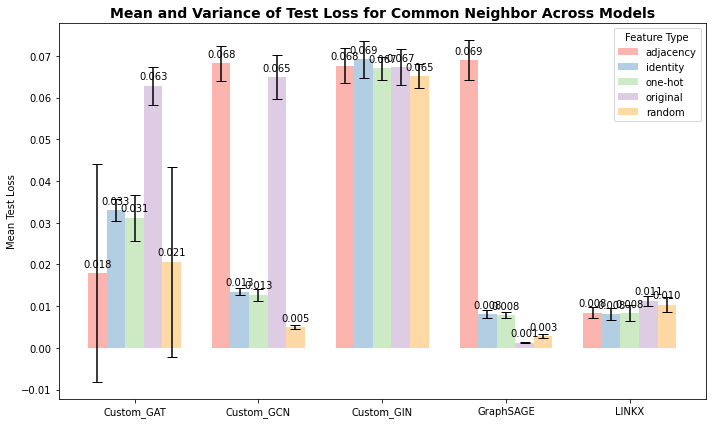

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data values from the merged statistics
df = merged_data
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df["Model"].unique()))  # x-axis positions for each method
width = 0.15  # Adjusted width for additional feature type

colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']  # Soft pastel shades

# Extract unique features and methods for grouping
unique_features = df["NodeFeat"].unique()
methods = df["Model"].unique()

complete_index = pd.MultiIndex.from_product([methods, unique_features], names=["Model", "NodeFeat"])
df = df.set_index(["Model", "NodeFeat"]).reindex(complete_index, fill_value=0).reset_index()

# Plot each feature's data for all models grouped by model type
for i, feature in enumerate(unique_features):
    feature_data = df[df["NodeFeat"] == feature]
    values = feature_data["Mean_Loss"].values
    errors = np.sqrt(feature_data["Variance_Loss"].values)  # Standard deviation for error bars

    # Plot bar with error bars
    ax.bar(x + i * width, values, width, yerr=errors, label=feature, color=colors[i], capsize=5)

    # Adding data labels for mean values
    for j, val in enumerate(values):
        ax.text(x[j] + i * width, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Mean Test Loss')
ax.set_title('Mean and Variance of Test Loss for Common Neighbor Across Models', loc='center', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(unique_features) - 1) / 2)
ax.set_xticklabels(methods)
ax.legend(loc='upper right', title="Feature Type")


plt.tight_layout()
plt.show()



### GCN 
$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{W}$

$\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops and 
$\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$ its diagonal degree matrix.

$    \mathbf{x}^{\prime}_i = \mathbf{W}^{\top} \sum_{j \in
    \mathcal{N}(i) \cup \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j
    \hat{d}_i}} \mathbf{x}_j $

$\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$, where $e_{j,i}$ denotes the edge weight from source node `j` to target node `i` (default: `1.0`)

### SAGE 
$\mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
    \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j $


$    \mathbf{x}_j \leftarrow \sigma ( \mathbf{W}_3 \mathbf{x}_j +
    \mathbf{b}) $

### GIN
$\mathbf{x}^{\prime}_i = h_{\mathbf{\Theta}} \left( (1 + \epsilon) \cdot
        \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \mathrm{ReLU}
        ( \mathbf{x}_j + \mathbf{e}_{j,i} ) \right)$

### LINKX
$\mathbf{H}_{\mathbf{A}} = \text{MLP}_{\mathbf{A}}(\mathbf{A})$

$\mathbf{H}_{\mathbf{X}} = \textrm{MLP}_{\mathbf{X}}(\mathbf{X})$

$\mathbf{Y} = \textrm{MLP}_{f} \left( \sigma \left( \mathbf{W}
[\mathbf{H}_{\mathbf{A}}, \mathbf{H}_{\mathbf{X}}] +
\mathbf{H}_{\mathbf{A}} + \mathbf{H}_{\mathbf{X}} \right) \right)$

In [6]:
import pandas as pd

import os


# Define the directory containing the files
results_dir = "results"
output_file = "merged_PPR_ddi.csv"

# List to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(results_dir):
    if filename.endswith("PPR_ddi.csv"):  # Check if file ends with 'CN_ddi.csv'
        file_path = os.path.join(results_dir, filename)
        print(f"Loading file: {file_path}")
        df = pd.read_csv(file_path)  # Read the CSV file
        df['source_file'] = filename  # Add a column to identify the source file
        dataframes.append(df)

# Concatenate all DataFrames
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.to_csv(output_file, index=False)
    print(f"Merged {len(dataframes)} files into {output_file}")
else:
    print("No files ending with 'PPR_ddi.csv' found in the directory.")



Loading file: results/Custom_GIN2PPR_ddi.csv
Loading file: results/GraphSAGE2PPR_ddi.csv
Loading file: results/LINKX2PPR_ddi.csv
Loading file: results/Custom_GAT2PPR_ddi.csv
Loading file: results/Custom_GCN2PPR_ddi.csv
Merged 5 files into merged_PPR_ddi.csv


PPR

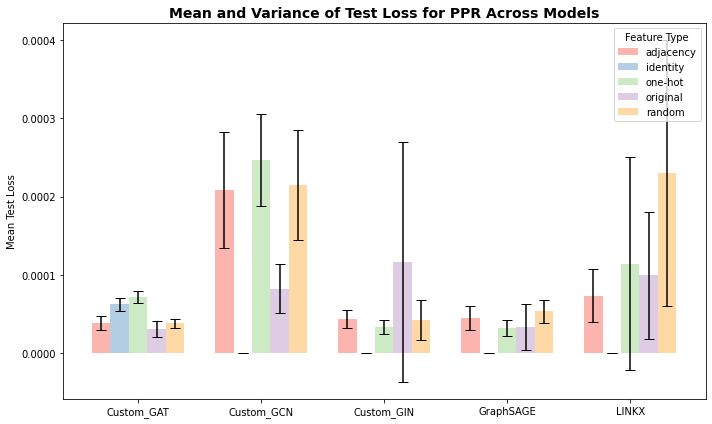

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data values from the merged statistics
df = merged_data
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df["Model"].unique()))  # x-axis positions for each method
width = 0.15  # Adjusted width for additional feature type

colors = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6']  # Soft pastel shades

# Extract unique features and methods for grouping
unique_features = df["NodeFeat"].unique()
methods = df["Model"].unique()

complete_index = pd.MultiIndex.from_product([methods, unique_features], names=["Model", "NodeFeat"])
df = df.set_index(["Model", "NodeFeat"]).reindex(complete_index, fill_value=0).reset_index()

# Plot each feature's data for all models grouped by model type
for i, feature in enumerate(unique_features):
    feature_data = df[df["NodeFeat"] == feature]
    values = feature_data["Mean_Loss"].values
    errors = np.sqrt(feature_data["Variance_Loss"].values)  # Standard deviation for error bars

    # Plot bar with error bars
    ax.bar(x + i * width, values, width, yerr=errors, label=feature, color=colors[i], capsize=5)

    # # Adding data labels for mean values
    # for j, val in enumerate(values):
    #     ax.text(x[j] + i * width, val + 0.001, f'{val:.3f}', ha='center', va='bottom')

# Set labels and title
ax.set_ylabel('Mean Test Loss')
ax.set_title('Mean and Variance of Test Loss for PPR Across Models', loc='center', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(unique_features) - 1) / 2)
ax.set_xticklabels(methods)
ax.legend(loc='upper right', title="Feature Type")

plt.tight_layout()
plt.show()


def sort_edge_index(edge_index):
    """Sort the edge index in ascending order according to the source node index."""

    src_index, sort_indices = torch.sort(edge_index[:, 0])
    dst_index = edge_index[sort_indices, 1]
    edge_reindex = torch.stack([src_index, dst_index])
    return edge_reindex, sort_indices


def Ben_PPR(A, edge_index, batch_size=10000):
    """
    The Personalized PageRank heuristic score.
    Need to install fast_pagerank by "pip install fast-pagerank"
    Too slow for large datasets now.
    :param A: A CSR matrix using the 'message passing' edges
    :param edge_index: The supervision edges to be scored
    :return:
    """
    edge_index = edge_index.t()
    from fast_pagerank import pagerank_power
    num_nodes = A.shape[0]
    edge_reindex, sort_indices = sort_edge_index(edge_index)
    
    
    scores = []
    visited = set([])
    j = 0
    for i in tqdm(range(edge_reindex.shape[1])):
        if i < j:
            continue
        
        src = edge_reindex[0, i]
        personalize = np.zeros(num_nodes)
        # get the ppr for the current source node
        personalize[src] = 1        
        
        # ppr initially start from srt code
        ppr = pagerank_power(A, p=0.85, personalize=personalize, tol=1e-7)
        
        j = i
        # avoid repeated calculation start at the same source 
        while edge_reindex[0, j] == src:
            j += 1
            if j == edge_reindex.shape[1]:
                break
            
        # all_dst 
        all_dst = edge_reindex[1, i:j]

        cur_scores = ppr[all_dst]
        if cur_scores.ndim == 0:
            cur_scores = np.expand_dims(cur_scores, 0)
        scores.append(np.array(cur_scores))

    scores = np.concatenate(scores, 0)
    print(f'evaluated PPR for {len(scores)} edges')
    
    return torch.FloatTensor(scores), edge_reindex
